In [9]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from 

In [2]:
df = pd.read_csv('variable_selected_county_dataset.csv', index_col=0)

<Axes: xlabel='date'>

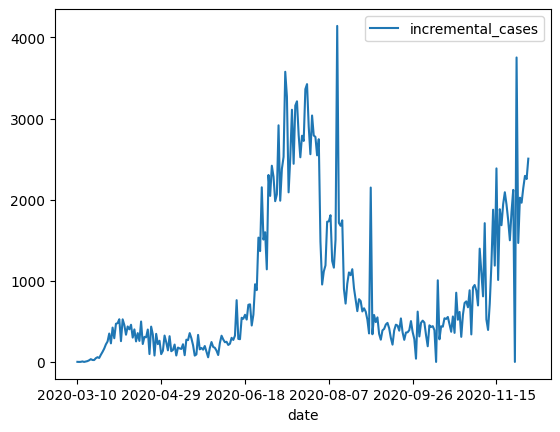

In [7]:
# get selected counties
miami = df[df.entity == 'Florida-Miami-Dade']
miami = miami[['date', 'incremental_cases']]
#miami.reset_index(inplace=True)
miami.plot(x='date', y='incremental_cases')


In [12]:
diffDf = miami.set_index('date')

In [71]:
#need to differentiate twice to not be stationary
statDF = diffDf.diff().diff()
firstVal = diffDf.diff(1).iloc[1,:].incremental_cases
firstDiff = diffDf.diff()
firstVal

-1.0

In [77]:
split = int(0.85 * len(statDF))
train = statDF.iloc[:split,:]
test = statDF.iloc[split:, :]
compareTest = diffDf.iloc[split:, :]

In [67]:
test

,incremental_cases
date,
2020-10-25,-403.0
2020-10-26,579.0
2020-10-27,-126.0
2020-10-28,-127.0
2020-10-29,-92.0
2020-10-30,283.0
2020-10-31,-754.0
2020-11-01,1123.0
2020-11-02,-549.0


In [76]:
diffDf

,incremental_cases
date,
2020-03-10,1.0
2020-03-11,0.0
2020-03-12,1.0
2020-03-13,6.0
2020-03-14,0.0
...,...
2020-11-30,1962.0
2020-12-01,2143.0
2020-12-02,2293.0


In [72]:
def fromTestDiffToActualInc(test, firstVal, secondVal):
    test.iloc[0,0] += firstVal
    test = test.cumsum()
    test.iloc[0,0] += secondVal
    return test.cumsum()

In [85]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)

In [99]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error



# evaluate parameters
p_values = [7, 9, 12]
d_values = [0, 1, 2]
q_values = [0, 1, 2]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            hyperPar = (p, d, q)
            model = ARIMA(train.incremental_cases, order=hyperPar)
            model.initialize_approximate_diffuse()
            model_fit = model.fit()
            # summary of fit model
            #print(model_fit.summary())
            # line plot of residuals
            #residuals = pd.DataFrame(model_fit.resid)
            #residuals.plot()
            #plt.show()
            # density plot of residuals
            #residuals.plot(kind='kde')
            #plt.show()
            # summary stats of residuals
            #print(residuals.describe())
            forecast = model_fit.forecast(steps=41)

            predictTest = pd.DataFrame(forecast)
            predictTest.columns=['incremental_cases']

            foo = pd.DataFrame(model_fit.fittedvalues, columns=['incremental_cases'])
            foo.iloc[1,0] = diffDf.diff().iloc[1,0]
            foo = foo.cumsum()
            firstVal = foo.iloc[-1,0].copy()
            
            foo.iloc[0,0] = diffDf.iloc[0,0]
            foo = foo.cumsum()
            secondVal = foo.iloc[-1,0].copy()



            fooooo = predictTest.copy()
            finalIncrementPreds = fromTestDiffToActualInc(fooooo, firstVal, secondVal)


            
            #mseEval = predictTest.incremental_cases - test.incremental_cases
            r2 = mean_squared_error(compareTest.incremental_cases, finalIncrementPreds.incremental_cases)
            if r2 < prev:
                prev = r2
                best = hyperPar
                
            print(r2, 'for parameters', hyperPar)

print(best, prev)

131056679.4079908 for parameters (7, 0, 0)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1027697807.8237182 for parameters (7, 0, 1)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2653954086.334824 for parameters (7, 0, 2)
9223869.96152579 for parameters (7, 1, 0)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


3050973694.690978 for parameters (7, 1, 1)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


28391038447.71744 for parameters (7, 1, 2)
1307942788.4230208 for parameters (7, 2, 0)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


25333149.04121278 for parameters (7, 2, 1)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


8447685450.905937 for parameters (7, 2, 2)
88166740.60636757 for parameters (9, 0, 0)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


12336393215.246489 for parameters (9, 0, 1)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


8079760629.137752 for parameters (9, 0, 2)
368057.8166057021 for parameters (9, 1, 0)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


3685484072.787312 for parameters (9, 1, 1)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1466635620.5532625 for parameters (9, 1, 2)
43848153.11234252 for parameters (9, 2, 0)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


11803718.448400585 for parameters (9, 2, 1)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


4266629403.405674 for parameters (9, 2, 2)
31111732.649418674 for parameters (12, 0, 0)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


728783737.5141749 for parameters (12, 0, 1)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


11033555510.712536 for parameters (12, 0, 2)
13337858.487250531 for parameters (12, 1, 0)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


8252915150.875042 for parameters (12, 1, 1)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1437931973.839175 for parameters (12, 1, 2)
122252839.60326439 for parameters (12, 2, 0)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


42406728.43203271 for parameters (12, 2, 1)


C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


4098889272.8889756 for parameters (12, 2, 2)
(9, 1, 0) 368057.8166057021


In [100]:
hyperPar = (9, 1, 0)
model = ARIMA(train.incremental_cases, order=hyperPar)
model.initialize_approximate_diffuse()
model_fit = model.fit()
# summary of fit model
#print(model_fit.summary())
# line plot of residuals
#residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()
#plt.show()
# density plot of residuals
#residuals.plot(kind='kde')
#plt.show()
# summary stats of residuals
#print(residuals.describe())
forecast = model_fit.forecast(steps=41)

predictTest = pd.DataFrame(forecast)
predictTest.columns=['incremental_cases']

foo = pd.DataFrame(model_fit.fittedvalues, columns=['incremental_cases'])
foo.iloc[1,0] = diffDf.diff().iloc[1,0]
foo = foo.cumsum()
firstVal = foo.iloc[-1,0].copy()

foo.iloc[0,0] = diffDf.iloc[0,0]
foo = foo.cumsum()
secondVal = foo.iloc[-1,0].copy()



fooooo = predictTest.copy()
finalIncrementPreds = fromTestDiffToActualInc(fooooo, firstVal, secondVal)



#mseEval = predictTest.incremental_cases - test.incremental_cases
r2 = mean_squared_error(compareTest.incremental_cases, finalIncrementPreds.incremental_cases)

    
print(r2, 'for parameters', hyperPar)
print(r2_score(compareTest.incremental_cases, finalIncrementPreds.incremental_cases), 'for parameters', hyperPar)

368057.8166057021 for parameters (9, 1, 0)
0.36616891960204945 for parameters (9, 1, 0)


In [90]:
train

,incremental_cases
date,
2020-03-10,NaN
2020-03-11,NaN
2020-03-12,2.0
2020-03-13,4.0
2020-03-14,-11.0
...,...
2020-10-20,277.0
2020-10-21,-390.0
2020-10-22,697.0
